In [3]:
#run this code to read players.csv data 
library(tidyverse)

players_data <- read.csv("data/players.csv") 

head(players_data) 

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Data Description
    players.csv Dataset**

- There are 196 observations
- 7 variables (experience, subscribe, hashedEmail, played_hours, name, gender, age)

**Issues in Dataset**
- Some variables are not relevant in the dataset in relation to our question, such as hashEmail. This dataset  will need to be tidied before using. 
- Some players in the dataset chose to not specify their gender. This can cause issues if gender is used as a variable in answering a question, since plots or averages can be inaccurate. 
- Some observations may be too high or too low, such as a player's hours played being too high. This could make a plot look messy, and it may need to be reconsidered whether that person's data should be used, since it is so different.
- Inconsistency in the variable names, such as "Age" being capitalized.
- Order of which data is read in (order of variables).

**Data Collection**
- The dataset was collected by a research group in computer science at UBC.
- Their goal was to collect data on how people play the video game MineCraft.
- They collected this data by creating a MineCraft server and observing players actions as they played. 
- Participants of all ages and skill level were included
- Data was collected on an excel spreadsheet 


Data Description 

| Variable      | Type      | Meaning                                      |
|----------------|-----------|----------------------------------------------|
| experience     | factor    | Playing experience of player in MineCraft. Either pro, amateur, regular, or beginner                         |
| subscribe      | logical   | States if player is subscribed to newsletter (true or false) |
| hashedEmail    | character | Email used by player in MineCraft                               |
| played_hours   | double    | Total hours played by player                        |
| name           | character | Name of user                                 |
| gender         | factor    | Gender of user                               |
| age            | integer   | Age of user (years)                          |


**Broad Question**
- What player characteristics and behaviours are most predictive of subscribing to a game related newsletter, and how do these features differ between various player types?

**Specific Question**
- Can player experience, hours played, and age predict whether a MineCraft player subscribes to the game's newsletter?

**How the Dataset Will Help Answer This Question**
- The dataset shows whether each individual is subscribed to the newsletter
- Players experience reflects on a player's engagement with the game, and can be analyzed in relation to subscription to a newsletter. By plotting points on a graph, we can see if there is a trend.
- Players hours played reflects on how often a player engages with the game, and can be analyzed the same way as players experience is, with a graph
- Players age may reflect how interested different age groups are in the game, and can be analyzed the same way.

**How to Wrangle the Dataset**
- Select variables specific to the question being answered
- Tidy the dataset by naming variables in similar matter (all lowercase)
- Split the data into a training and testing dataset  

In [7]:
#run this code to read tidy data 
library(tidyverse)

players_data_tidy <- players_data |>
    select(name, gender, Age, played_hours, experience, subscribe, -hashedEmail, -gender) |>
    rename(age = Age) |>
    arrange(age)

players_data_tidy

name,age,played_hours,experience,subscribe
<chr>,<int>,<dbl>,<chr>,<lgl>
Morgan,9,30.3,Pro,TRUE
Zane,10,3.6,Regular,TRUE
Rafael,11,2.9,Amateur,TRUE
Gray,12,0.5,Pro,TRUE
Kyrie,14,17.2,Amateur,TRUE
Carmen,14,0.2,Regular,TRUE
Ophelia,15,0.1,Regular,TRUE
Hayden,15,0.1,Pro,TRUE
Delara,16,150.0,Amateur,TRUE


In [5]:
#Compute mean value for each quantitative variable and report mean values in table format 
summary_mean <- players_data |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_played_hours = mean(played_hours, na.rm = TRUE))

summary_table <- summary_mean |>
    pivot_longer(cols = everything(), 
                 names_to = "variable", 
                 values_to = "mean")
summary_table 

variable,mean
<chr>,<dbl>
mean_age,21.139175
mean_played_hours,5.845918


Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


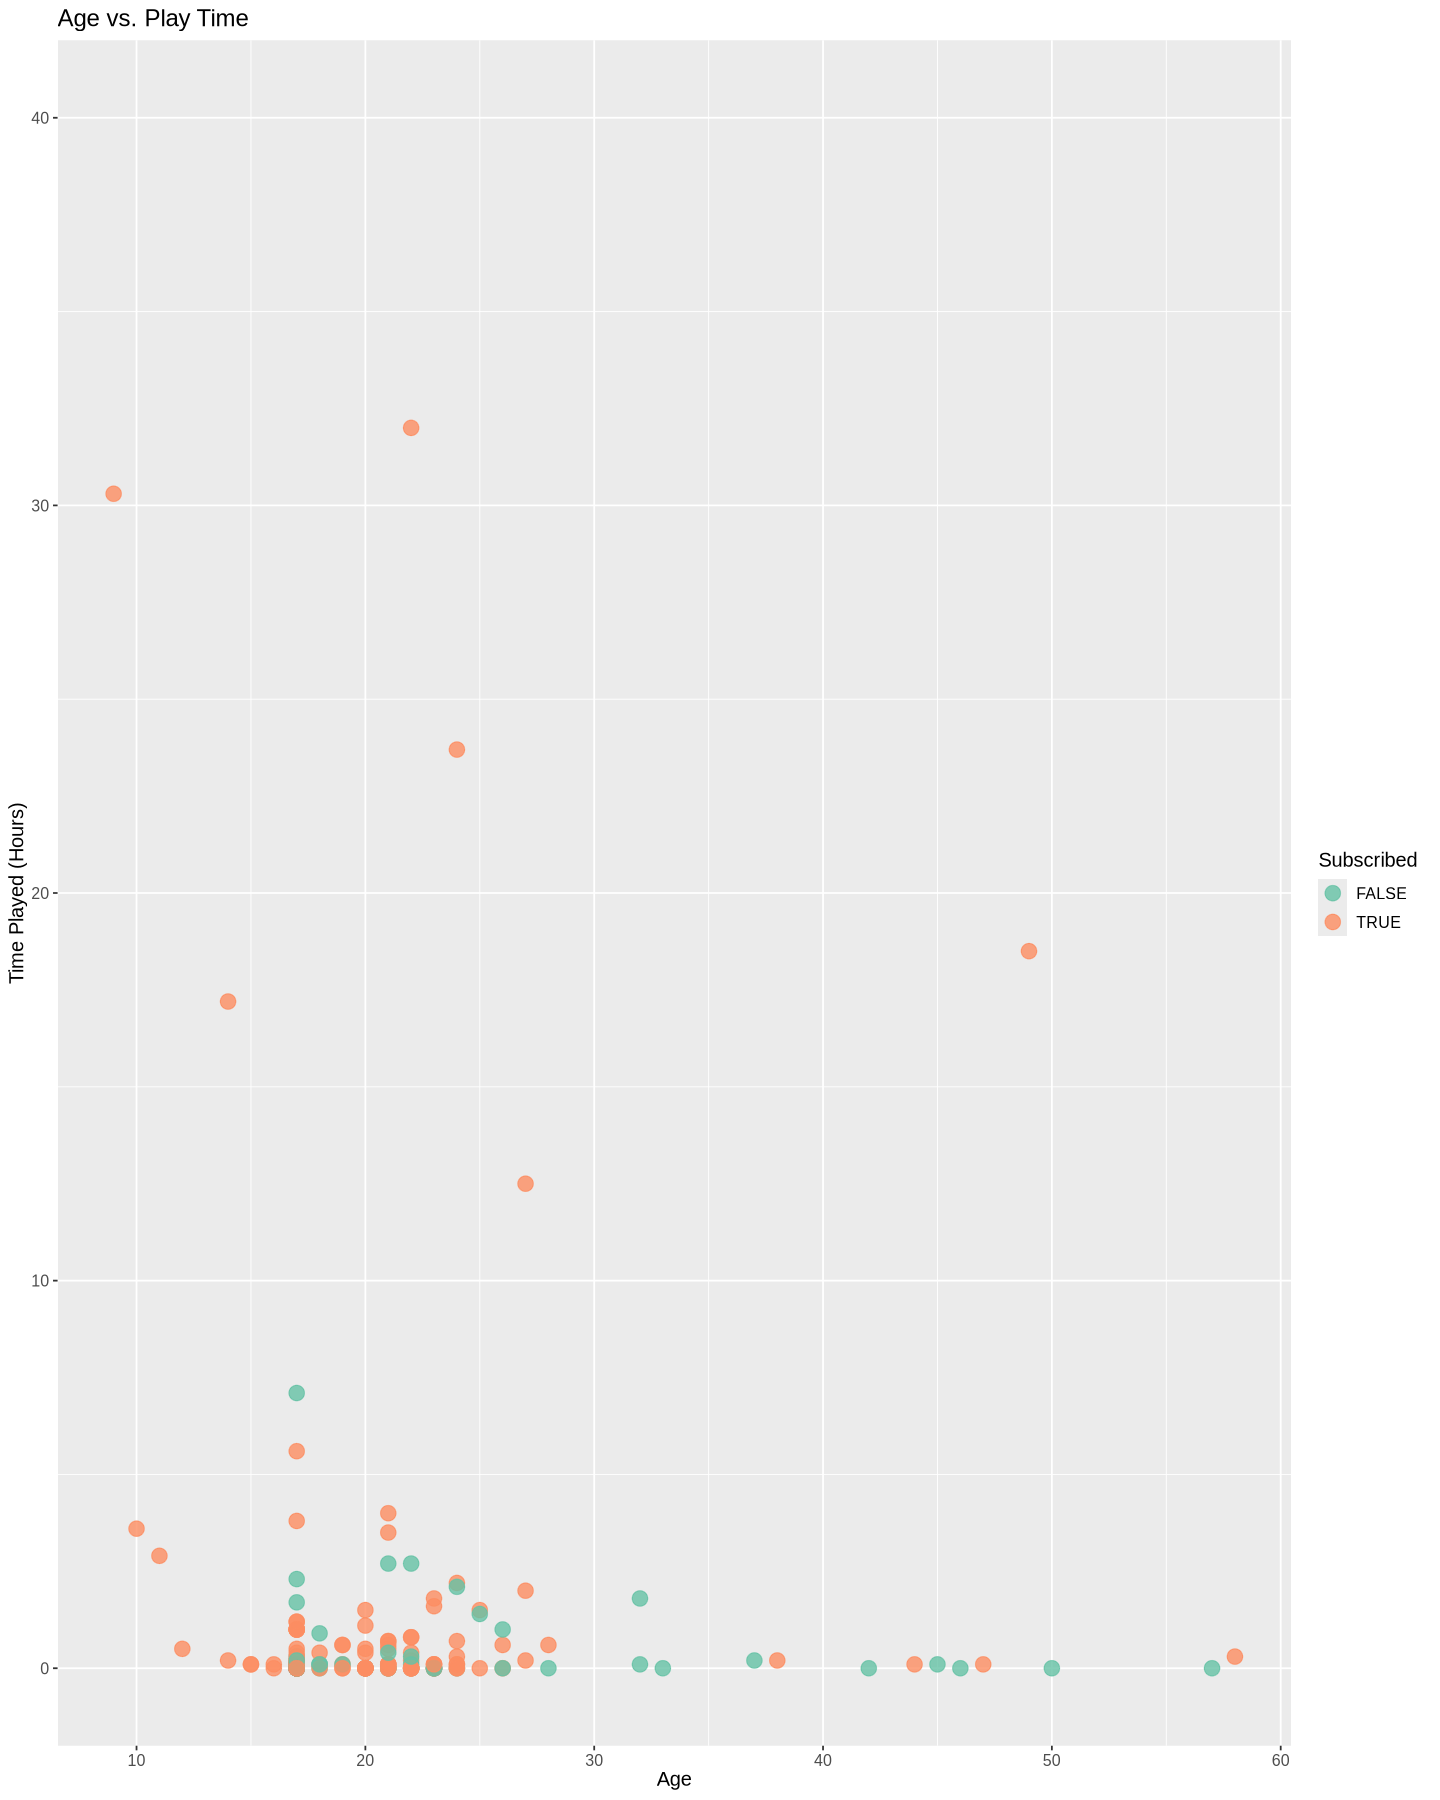

In [23]:
#Make exploratory visualizations
options(repr.plot.width = 12, repr.plot.height = 15)
hours_plot <- players_data |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) + 
    geom_point(size = 4, alpha = 0.8) +
    labs(title = "Age vs. Play Time",
         x = "Age", 
         y = "Time Played (Hours)",
         color = "Subscribed") +
    ylim(0.0, 40) +
    theme(text = element_text(size = 12)) +
    scale_color_brewer(palette = "Set2")

hours_plot

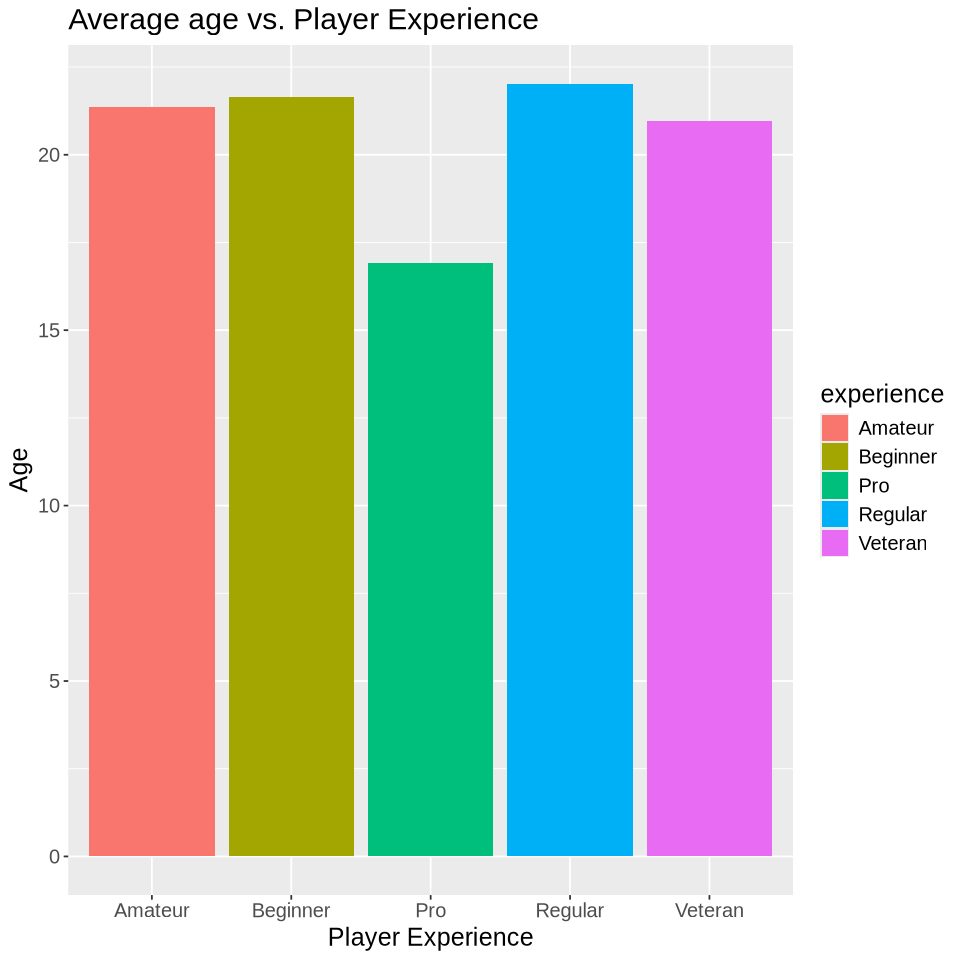

In [35]:
#Make exploratory visualizations
library(ggplot2)
library(dplyr)

options(repr.plot.width = 8, repr.plot.height = 8)
age_mean <- players_data |>
    group_by(experience) |>
    summarize(mean_age = mean(age, na.rm = TRUE))

experience_plot <- ggplot(age_mean, aes(x = experience, y = mean_age, fill = experience)) +
    geom_col() +
    labs(title = "Average age vs. Player Experience", 
         x = "Player Experience",
         y = "Age") +
    theme(text = element_text(size = 15))


experience_plot

**Methods and Plan**

**KNN classification is the most appropriate method to answer this question**
- this is because we are predicting a true/false variable instead of a numeric one
- predictions on non-linear relationships can be made, which is the case for this question
  
**Limitations include choosing the right number of neighbors, scaling, and how far apart the points are**

- the number of neighbors chosen can change how accurate the resulting prediction is
- not scaling the axis can give innacurate results
- If many points are close together, it may be hard to predict
  
**Selecting and composing a model**
- Tune different k values by testing a number of k values to see which is most accurate
- Use cross validation
- Use age, experience, and hours played as predictors
- Prediction is true/false for subscribe

**Processing the data**
- Select variables relevant to the question asked
- After tidying the data, split data in 75/25 format (75 for training, 25 for testing)
- Use k fold cross validation and determine a suitable k value 

**Github Link**
https://github.com/Amisha-B32/individual_project_repo.git